# A Basic Introduction

In the following introduction, we showcase some common use cases of `PineAPPL`
that are available through the Python interface. For more details about all
the available functionalities, refer to the [API documentation](https://pineappl.readthedocs.io/en/latest/modules/pineappl.html#).

## Setting up

In order to start using `PineAPPL`, one first needs to install it. 
The easiest way to install the latest stable version is via `pip` 
using the following command:

In order to check that `PineAPPL` was installed properly, one can try to import it:

In [1]:
import pineappl

If the above command was successful (did not result in an error), we can
download the `PineAPPL` grid that will be used throughout this tutorial.

In [2]:
!wget --no-verbose --no-clobber 'https://data.nnpdf.science/pineappl/test-data/LHCB_DY_8TEV.pineappl.lz4'

We can now load the downloaded grid by running the following:

In [3]:
# Load the PineAPPL grid
grid = pineappl.grid.Grid.read("./LHCB_DY_8TEV.pineappl.lz4")

**NOTE:** For the `pineappl.grid.Grid.read()` function, both `.pineappl` and `.pineappl.lz4` 
extensions are acceptable, as long as they are consistent. Without the `.lz4` extension, the
grid is assumed to not be compressed.

## How can I convolve a given PineAPPL grid with a PDF?

In [4]:
# We first need to load the PDF set with LHAPDF
import lhapdf
import numpy as np

# `Polars` is a better alternative to Pandas (written in Rust!)
# If you don't have it installed. Simply run `pip install polars`
import polars as pl

lhapdf.setVerbosity(0)
# Choose the PDF set to be used
pdfset = "NNPDF40_nnlo_as_01180"
# Use the central PDF, ie. member ID=0
pdf = lhapdf.mkPDF(pdfset, 0)

In order to convolve a grid, we need to specify the types of convolutions that are required.
This includes the polarization and the PDG IDs of the involved hadrons, as well as wether or
not the hadron is in the initial- or final-state.

In our example, the grid involves two initial-state unpolarized protons. We can therefore
construct the convolution types as follows:

In [5]:
from pineappl.convolutions import Conv, ConvType

conv_type = ConvType(polarized=False, time_like=False)
conv_object = Conv(convolution_types=conv_type, pid=2212)

Our grid can now be convolved with our PDF set using the `convolve()` function.

In [6]:
predictions = grid.convolve(
    pdg_convs=[conv_object, conv_object],  # Similar convolutions for symmetric protons
    xfxs=[pdf.xfxQ2, pdf.xfxQ2],  # Similar PDF sets for symmetric protons
    alphas=pdf.alphasQ2,
)
df_preds = pl.DataFrame(
    {
        "bins": range(predictions.size),
        "predictions": predictions,
    }
)
df_preds

bins,predictions
i64,f64
0,8.159231
1,23.890855
2,38.306994
3,51.278627
4,62.349204
…,…
13,22.640245
14,12.927123
15,6.138797


We can see that `convolve()` can perform convolutions with an arbitrary number of distributions. This is
why `pdf_convs` and `xfxs` are lists that respectively take all the types of convolutions and distributions
corresponding to the involved hadrons.

**NOTE:** If the hadrons have the same type of convolutions and require the convolution to the same distribution,
then only one single element can be passed to the list:

```python
# Pass the shared convolution type and distribution to all hadrons
predictions = grid.convolve(
    pdg_convs=[conv_object],
    xfxs=[pdf.xfxQ2],
    alphas=pdf.alphasQ2,
)
```

The length of `predictions` is the same as the number of bins that define the
observable in question. In our example, it is the inclusive cross-section for
Z boson production in bins of the muon pseudorapidity at 8 TeV. See 
[arXiv:1511.08039](https://arxiv.org/abs/1511.08039) for more details, with the
corresponding [HepData](https://www.hepdata.net/record/ins1406555) tables.

To see that our predictions are consistent with the experimental measurements,
we can plot a comparison of the two using **only** the central values.

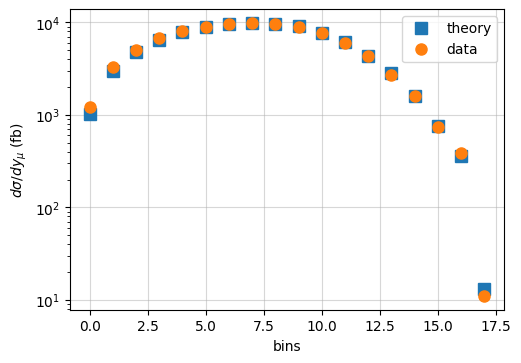

In [7]:
import matplotlib.pyplot as plt

# Experimental central values as provided by HepData
data_central = np.array(
    [
        1223.0,
        3263.0,
        4983.0,
        6719.0,
        8051.0,
        8967.0,
        9561.0,
        9822.0,
        9721.0,
        9030.0,
        7748.0,
        6059.0,
        4385.0,
        2724.0,
        1584.0,
        749.0,
        383.0,
        11.0,
    ]
)

# Normalization for each bin. See Section below for more details.
bin_norm = np.array([0.125 for _ in range(predictions.size - 2)] + [0.250, 0.250])

fig, ax = plt.subplots(figsize=(5.6, 3.9))
# Factor of `1e3` takes into account the unit conversion into `fb`
ax.plot(
    df_preds["bins"],
    1e3 * bin_norm * df_preds["predictions"],
    "s",
    markersize=8,
    label="theory",
)
ax.plot(df_preds["bins"], data_central, "o", markersize=8, label="data")
ax.grid(True, alpha=0.5)
ax.set_yscale("log")
ax.set_xlabel("bins")
ax.set_ylabel(r"$d\sigma / dy_\mu$ (fb)")
ax.legend()

plt.show()

As we can see, the theory predictions agree fairly well with the experimental
measurements. However, in order to have a meaningful comparison, one needs to
include all sources of experimental and theory uncertainties. **Notice** that
in the plot above, we are accounting for the change in normalization related
to each bin, something that we can directly modify inside the PineAPPL grid as 
we will see later.

**NOTE:** As mentioned before, if the two initial state hadrons are different 
(as is the case in $pp$ collisions in which one of the protons is polarized),
then one can convolve the grid with **two** different PDF sets using the `convolve()` 
function:

```python
# Define the convolution types for each of the (un)polarized hadrons
pol_type = ConvType(polarized=True, time_like=False) # `polarized = True`
pol_object = Conv(convolution_types=pol_type, pid=2212)

unpol_type = ConvType(polarized=False, time_like=False)
unpol_object = Conv(convolution_types=conv_type, pid=2212)

# Convolve the two initial state hadrons with different PDF sets
predictions = predictions = grid.convolve(
    pdg_convs=[pol_object, conv_object],
    xfxs=[polarized_pdf.xfxQ2, 2212, unpolarized_pdf.xfxQ2],
    alphas=pdf.alphasQ2,
)
```

**NOTE:** The same function `convolve` also works for convolving FK tables with PDF sets.

## How can I get information on the contents of a given PineAPPL grid?

Once the `PineAPPL` grid is loaded, one can look into its contents and modify them.
Below we illustrate how to extract the most common information from a given grid.

#### Contributing channels

In [8]:
# To get all the contributing channels
for idx, c in enumerate(grid.channels()):
    print(f"{idx}: {c}")

0: [([2, -2], 1.0), ([4, -4], 1.0)]
1: [([0, -4], 1.0), ([0, -2], 1.0)]
2: [([22, -4], 1.0), ([22, -2], 1.0)]
3: [([2, 0], 1.0), ([4, 0], 1.0)]
4: [([2, 22], 1.0), ([4, 22], 1.0)]
5: [([1, -1], 1.0), ([3, -3], 1.0)]
6: [([0, -3], 1.0), ([0, -1], 1.0)]
7: [([22, -3], 1.0), ([22, -1], 1.0)]
8: [([1, 0], 1.0), ([3, 0], 1.0)]
9: [([1, 22], 1.0), ([3, 22], 1.0)]
10: [([5, -5], 1.0)]
11: [([0, -5], 1.0)]
12: [([22, -5], 1.0)]
13: [([5, 0], 1.0)]
14: [([5, 22], 1.0)]
15: [([22, 22], 1.0)]
16: [([-5, 22], 1.0), ([-3, 22], 1.0), ([-1, 22], 1.0)]
17: [([1, 22], 1.0), ([3, 22], 1.0), ([5, 22], 1.0)]


The above prints out all the contributing channels where the first
two elements of the tuple represent the particle PID (following the
PDG conventions). For instance, in the first entry, the up-antiup
`(2,-2)` and charm-anticharm `(4,-4)` initial states are merged
together, each with a multiplicative factor of `1`. In general this 
number can be different from `1`, if the Monte Carlo decides to factor 
out CKM values or electric charges.

#### Perturbative orders

In [9]:
# To get the information on the orders:
orders = []
for idx, o in enumerate(grid.orders()):
    orders.append(o.as_tuple())

df_orders = pl.DataFrame(np.array(orders), schema=["as", "a", "lf", "lr", "la"])
df_orders.with_row_index("Index")

Index,as,a,lf,lr,la
u32,i64,i64,i64,i64,i64
0,0,2,0,0,0
1,1,2,0,0,0
2,1,2,1,0,0
3,1,2,0,1,0
4,0,3,0,0,0
5,0,3,1,0,0
6,0,3,0,1,0


The table above lists the perturbative orders contained in the
grid where the powers of the strong coupling $a_s$, the electroweak
coupling $a$, the factorization $\ell_F = \log(\mu_F^2/Q^2)$, renormalization $\ell_R=\log(\mu_R^2/Q^2)$,
and fragmentation $\ell_A=\log(\mu_A^2/Q^2)$
logs are shown. For instance, the first index shows that the grid 
contains a leading-order (LO) which has the coupling $a_s^2$.

#### Observable binning

Grids often correspond to an dataset, which correspond to an observable measured at several kinematic configurations, or bins.
The bins might be just 1 dimensional, as is the case here with rapidity, or for more complicated measurements higher dimensional.
Each bin is characterized by its left and right border.

In [10]:
# To get the bin configurations
bin_dims = grid.bin_dimensions()

# Get the bin specifications.
bin_specs = np.array(grid.bin_limits())

# Each element of bins is an object with a left and right limit and
# an associated bin normalization.
df = pl.DataFrame({})
for bin_dim in range(bin_dims):
    df = pl.concat(
        [
            df,
            pl.DataFrame(
                {
                    f"dim {bin_dim} left": bin_specs[:, bin_dim, 0],
                    f"dim {bin_dim} right": bin_specs[:, bin_dim, 1],
                }
            ),
        ],
        how="vertical",
    )
df

dim 0 left,dim 0 right
f64,f64
2.0,2.125
2.125,2.25
2.25,2.375
2.375,2.5
2.5,2.625
…,…
3.625,3.75
3.75,3.875
3.875,4.0


## How can I edit a grid?

Sometimes it is required to modify the contents of a grid for various
reasons (like plotting for example, as we saw earlier). The contents 
of PineAPPL grids can be edited in various ways. In our example, we 
are going to change the normalization related to each bin in order for
our observable to match the experimental measurements (see Section above).

Let us first check the normalizations before we modify them:

In [11]:
df_bins = pl.DataFrame({"bin normalization": grid.bin_normalizations()})
df_bins.with_row_index()

index,bin normalization
u32,f64
0,0.125
1,0.125
2,0.125
3,0.125
4,0.125
…,…
13,0.125
14,0.125
15,0.125


The column `bin normalization` shows the factor that all convolutions are
divided with. In our case, these values should be `1` in order to match
the experimental measurements.

In [12]:
# Import the Module to set bin specifications
from pineappl.boc import BinsWithFillLimits

# Extract the left & right bin limits
bin_limits = [
    [(bin_specs[b, d, 0], bin_specs[b, d, 1]) for d in range(bin_dims)]
    for b in range(grid.len())
]

# Set the normalization factor to `1`
normalizations = [1.0 for _ in grid.bin_normalizations()]

# Instantiate the bin spec object
bin_configs = BinsWithFillLimits.from_limits_and_normalizations(
    limits=bin_limits,
    normalizations=normalizations,
)

# Set the updated bin configurations
grid.set_bwfl(bin_configs)

# Save the modified grid
grid.write_lz4("./LHCB_DY_8TEV_custom_normalizations.pineappl.lz4")

We can now check that the normalizations have indeed been changed:

In [13]:
# Load our modified grids
grid_nrm = pineappl.grid.Grid.read("./LHCB_DY_8TEV_custom_normalizations.pineappl.lz4")
df_nbins = pl.DataFrame({"bin normalization": grid_nrm.bin_normalizations()})
df_nbins.with_row_index()

index,bin normalization
u32,f64
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
…,…
13,1.0
14,1.0
15,1.0


## Fast-Kernel (FK) tables

Fast-kernel (FK) tables are a special kind of grid, which contain the
Evolution Kernel Operators ([EKO](https://eko.readthedocs.io/))
which encode the DGLAP evolution equations. Furthermore, FK tables do not
have perturbative orders while PineAPPL grids do.

You can load them as well, using the FK interface:

```python
# Loading a FK table
fk = pineappl.fk_table.FkTable.read("path/to/fktable.pineappl.lz4")
```